# Análisis de series temporales - Trabajo práctico

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import curve_fit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAXfrom pylab import rcParams
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from scipy import signal
from scipy.special import inv_boxcox

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Análisis inicial de los datos

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/TrafficPrediction.csv")

In [6]:
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


Cambiamos el formato de "DataTime" de object a datetime.

In [8]:
df["DateTime"] = pd.to_datetime(df["DateTime"], format='%Y-%m-%d %H:%M:%S')

Verificamos cuantos cruces contempla el dataset y la cantidad de datos disponibles para cada uno.

In [9]:
print(df.Junction.value_counts())

1    14592
2    14592
3    14592
4     4344
Name: Junction, dtype: int64


Se grafica los 4 cruces para escoger entre ellos el que tenga una dinámica más interesante (subjetivamente) para el análisis.

Text(0, 0.5, 'Cantidad de vehículos')

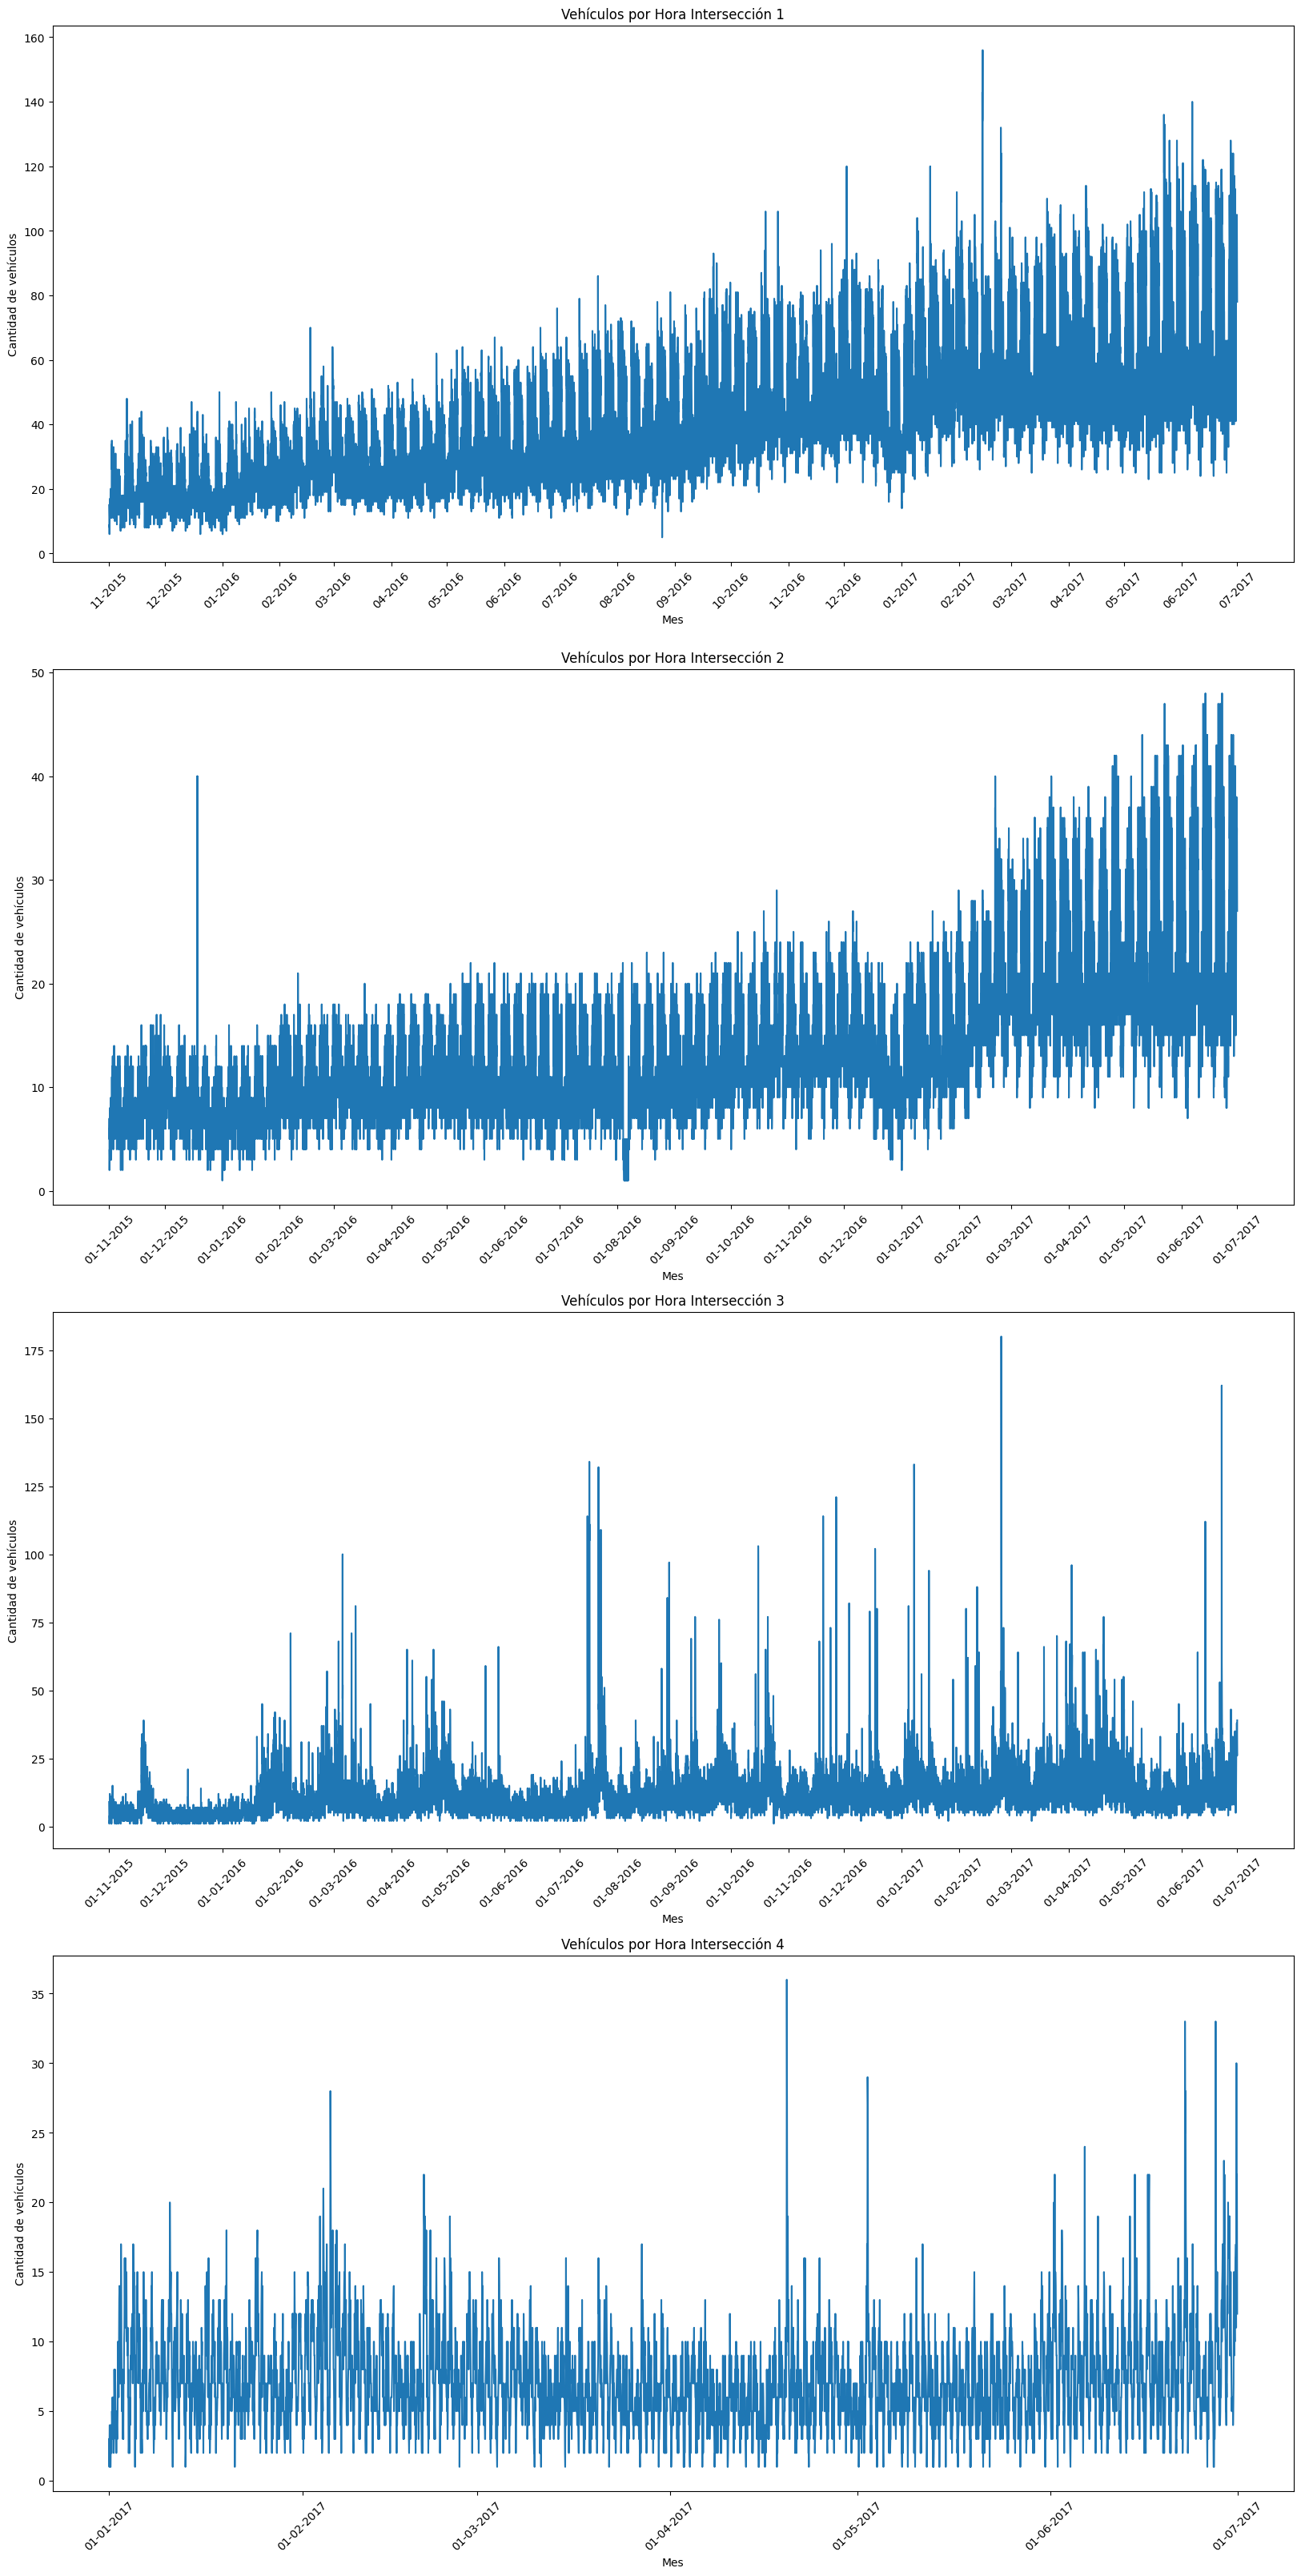

In [10]:
# Gráficas
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=[20,40])

ax1.plot(df.DateTime[df.Junction==1],df.Vehicles[df.Junction==1])
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax1.set_title("Vehículos por Hora Intersección 1")
ax1.set_xlabel("Mes")
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_ylabel("Cantidad de vehículos")

ax2.plot(df.DateTime[df.Junction==2],df.Vehicles[df.Junction==2])
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax2.set_title("Vehículos por Hora Intersección 2")
ax2.set_xlabel("Mes")
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_ylabel("Cantidad de vehículos")

ax3.plot(df.DateTime[df.Junction==3],df.Vehicles[df.Junction==3])
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax3.set_title("Vehículos por Hora Intersección 3")
ax3.set_xlabel("Mes")
ax3.tick_params(axis='x', labelrotation=45)
ax3.set_ylabel("Cantidad de vehículos")

ax4.plot(df.DateTime[df.Junction==4],df.Vehicles[df.Junction==4])
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax4.set_title("Vehículos por Hora Intersección 4")
ax4.set_xlabel("Mes")
ax4.tick_params(axis='x', labelrotation=45)
ax4.set_ylabel("Cantidad de vehículos")

Se decide trabajar con el cruce 2, porque los cruces 1 y 2 presentan ciclos más claros, al parecer semanales y mensuales, que pueden facilitar el análisis; así como también un comportamiento creciente más evidente, tal como se esperaría por el tipo de datos. Se descarta el cruce 3 porque no se observa claramente el crecimiento en la cantidad de vehículos a lo largo del tiempo, y el cruce 4 por la cantidad reducida de datos disponibles.

In [11]:
df.drop(df[(df['Junction'] != 2)].index, inplace=True)
df.head()

,DateTime,Junction,Vehicles,ID
14592,2015-11-01 00:00:00,2,6,20151101002
14593,2015-11-01 01:00:00,2,6,20151101012
14594,2015-11-01 02:00:00,2,5,20151101022
14595,2015-11-01 03:00:00,2,6,20151101032
14596,2015-11-01 04:00:00,2,7,20151101042


In [ ]:
"""
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=[20,30])

ax1.plot(df.DateTime[(df.DateTime>'2016-07-01 00:00:00') & (df.DateTime<'2016-08-01 00:00:00')],df.Vehicles[(df.DateTime>'2016-07-01 00:00:00') & (df.DateTime<'2016-08-01 00:00:00')])
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.set_title("Vehículos por Hora Intersección 2")
ax1.set_xlabel("Día")
ax1.tick_params(axis='x', labelrotation=45)
ax1.set_ylabel("Cantidad de vehículos")

ax2.plot(df.DateTime[(df.DateTime>'2016-08-01 00:00:00') & (df.DateTime<'2016-09-01 00:00:00')],df.Vehicles[(df.DateTime>'2016-08-01 00:00:00') & (df.DateTime<'2016-09-01 00:00:00')])
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax2.set_title("Vehículos por Hora Intersección 2")
ax2.set_xlabel("Día")
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_ylabel("Cantidad de vehículos")

ax3.plot(df.DateTime[(df.DateTime>'2016-09-01 00:00:00') & (df.DateTime<'2016-10-01 00:00:00')],df.Vehicles[(df.DateTime>'2016-09-01 00:00:00') & (df.DateTime<'2016-10-01 00:00:00')])
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax3.set_title("Vehículos por Hora Intersección 2")
ax3.set_xlabel("Día")
ax3.tick_params(axis='x', labelrotation=45)
ax3.set_ylabel("Cantidad de vehículos")
"""

## Descomposición con el modelo aditivo

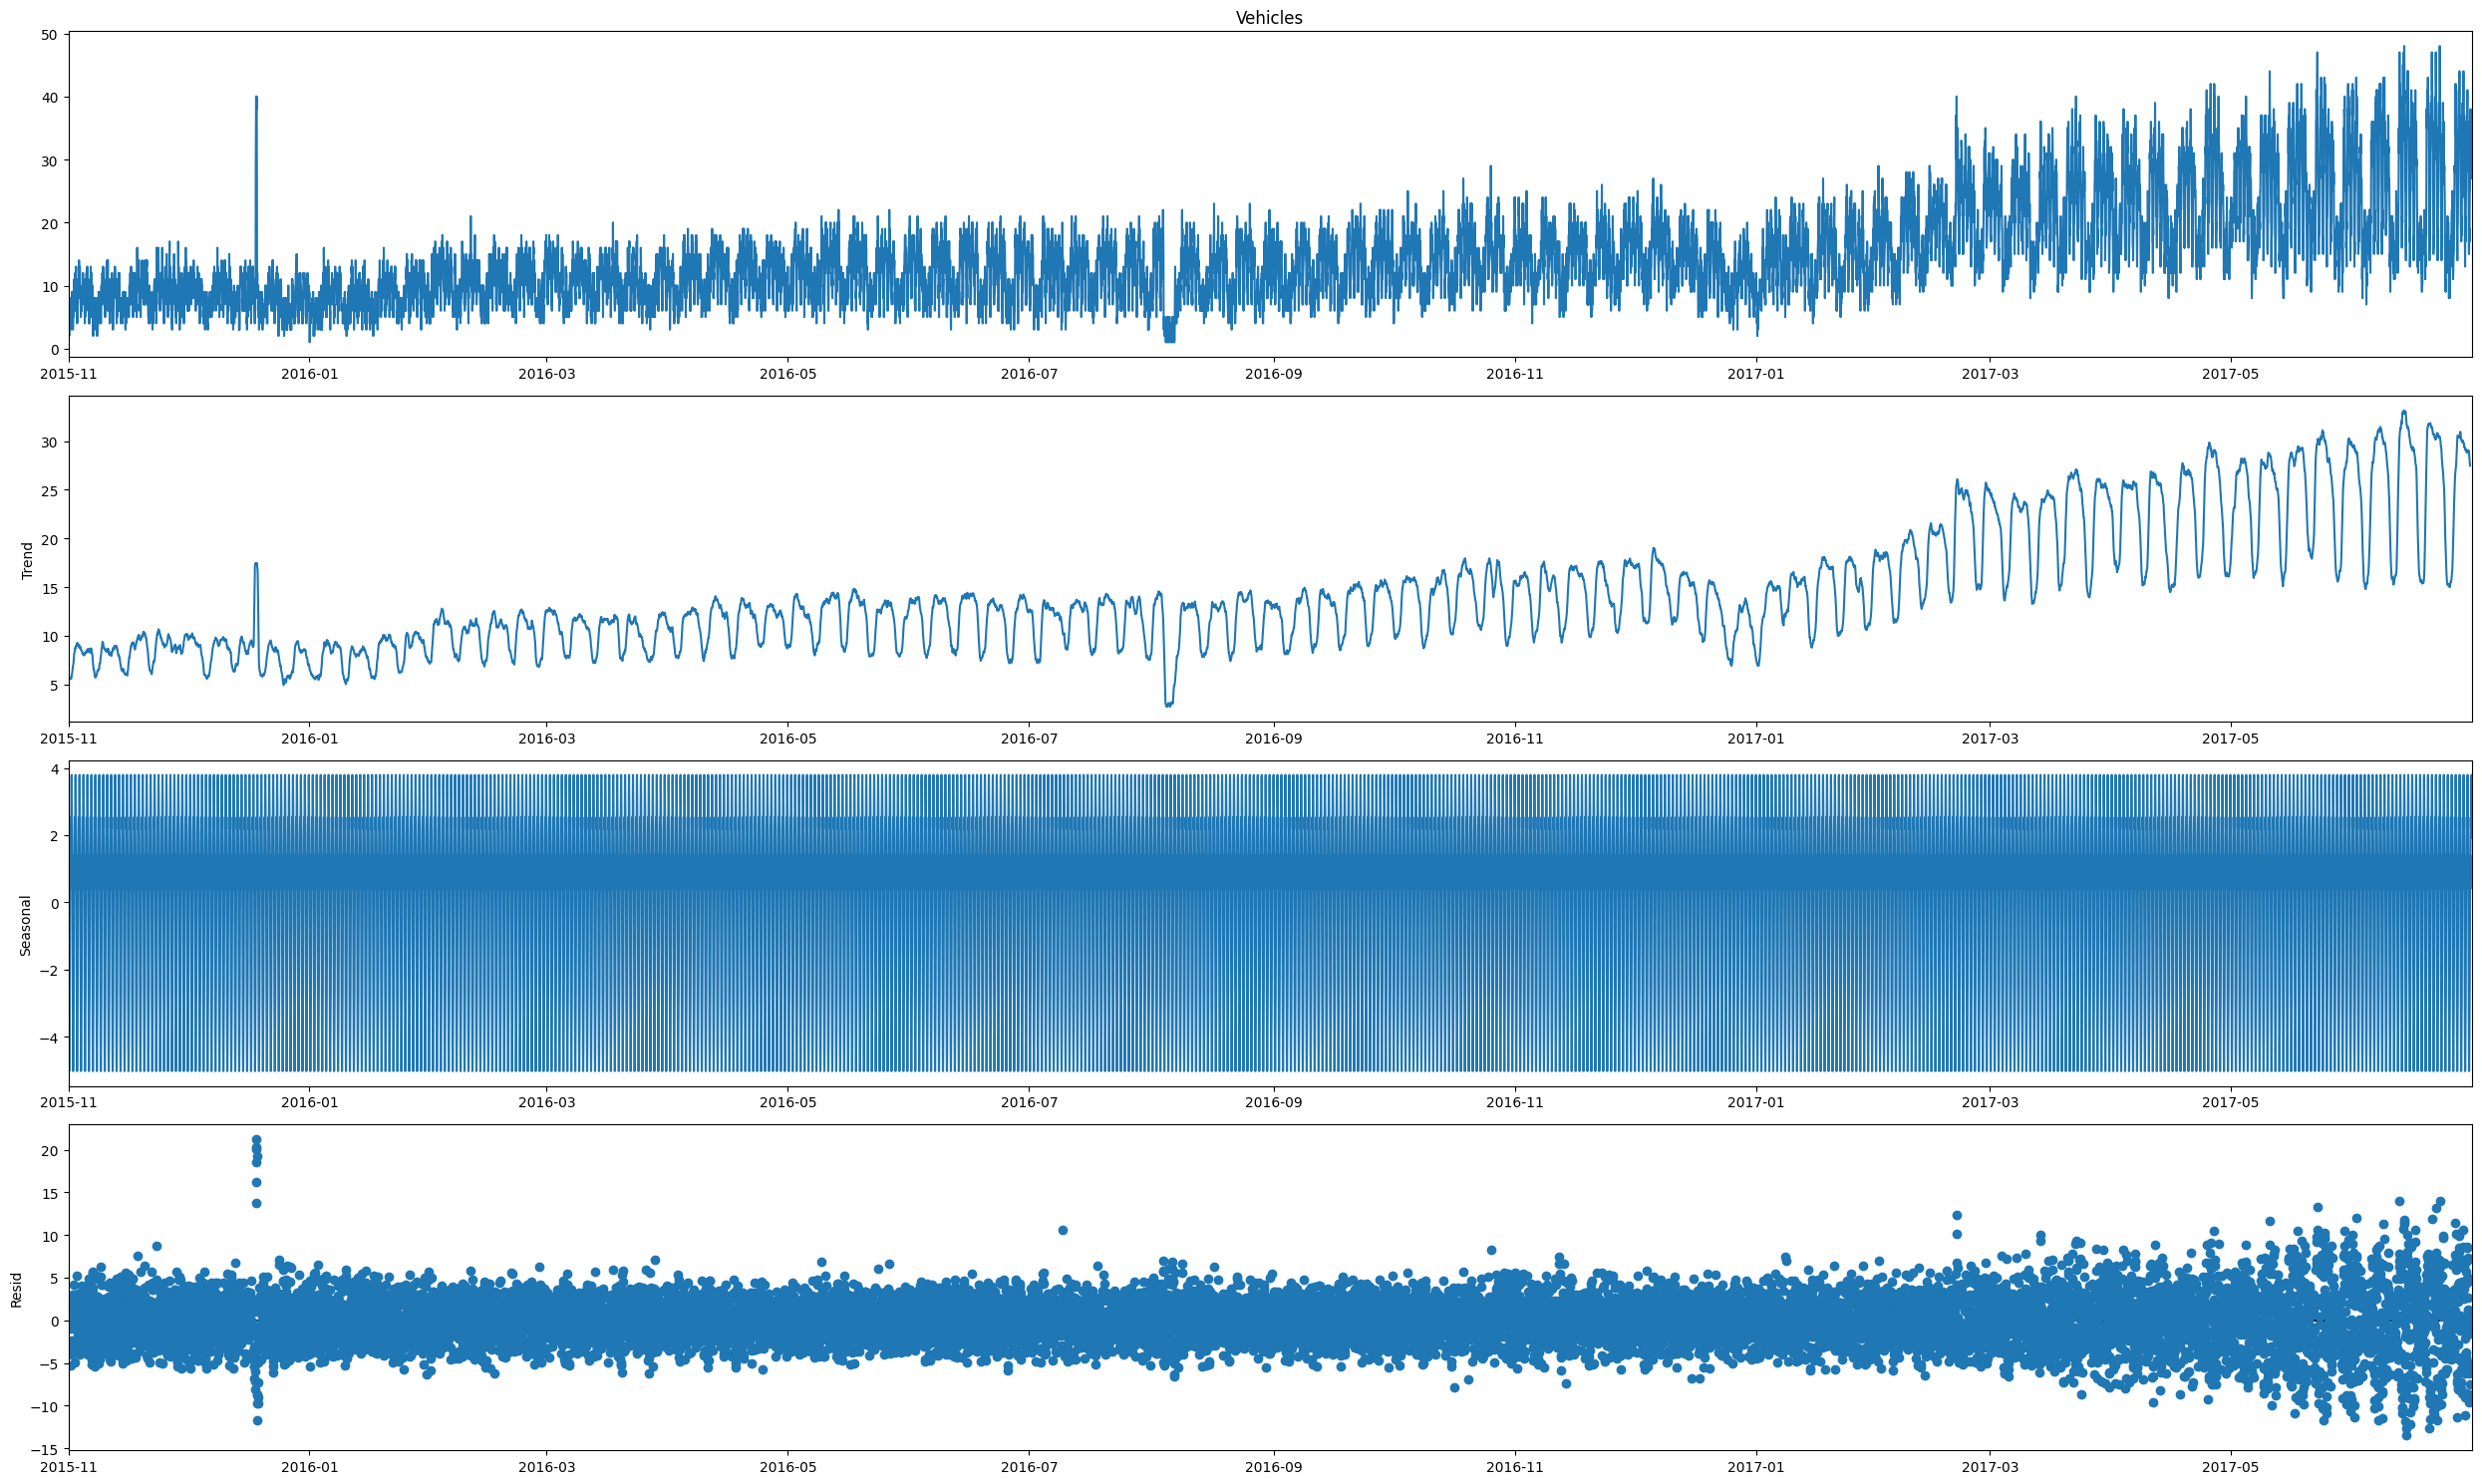

In [12]:
periodo = 24
new_df= df.set_index('DateTime')
parameters = {'figure.figsize': (25,15)}
plt.rcParams.update(parameters)
decompose = seasonal_decompose(new_df.Vehicles, model='additive', period=periodo)
trend = decompose.trend
seasonal = decompose.seasonal
residual = decompose.resid
decompose.plot();

## Extracción de tendencia y ajuste de modelo determinístico

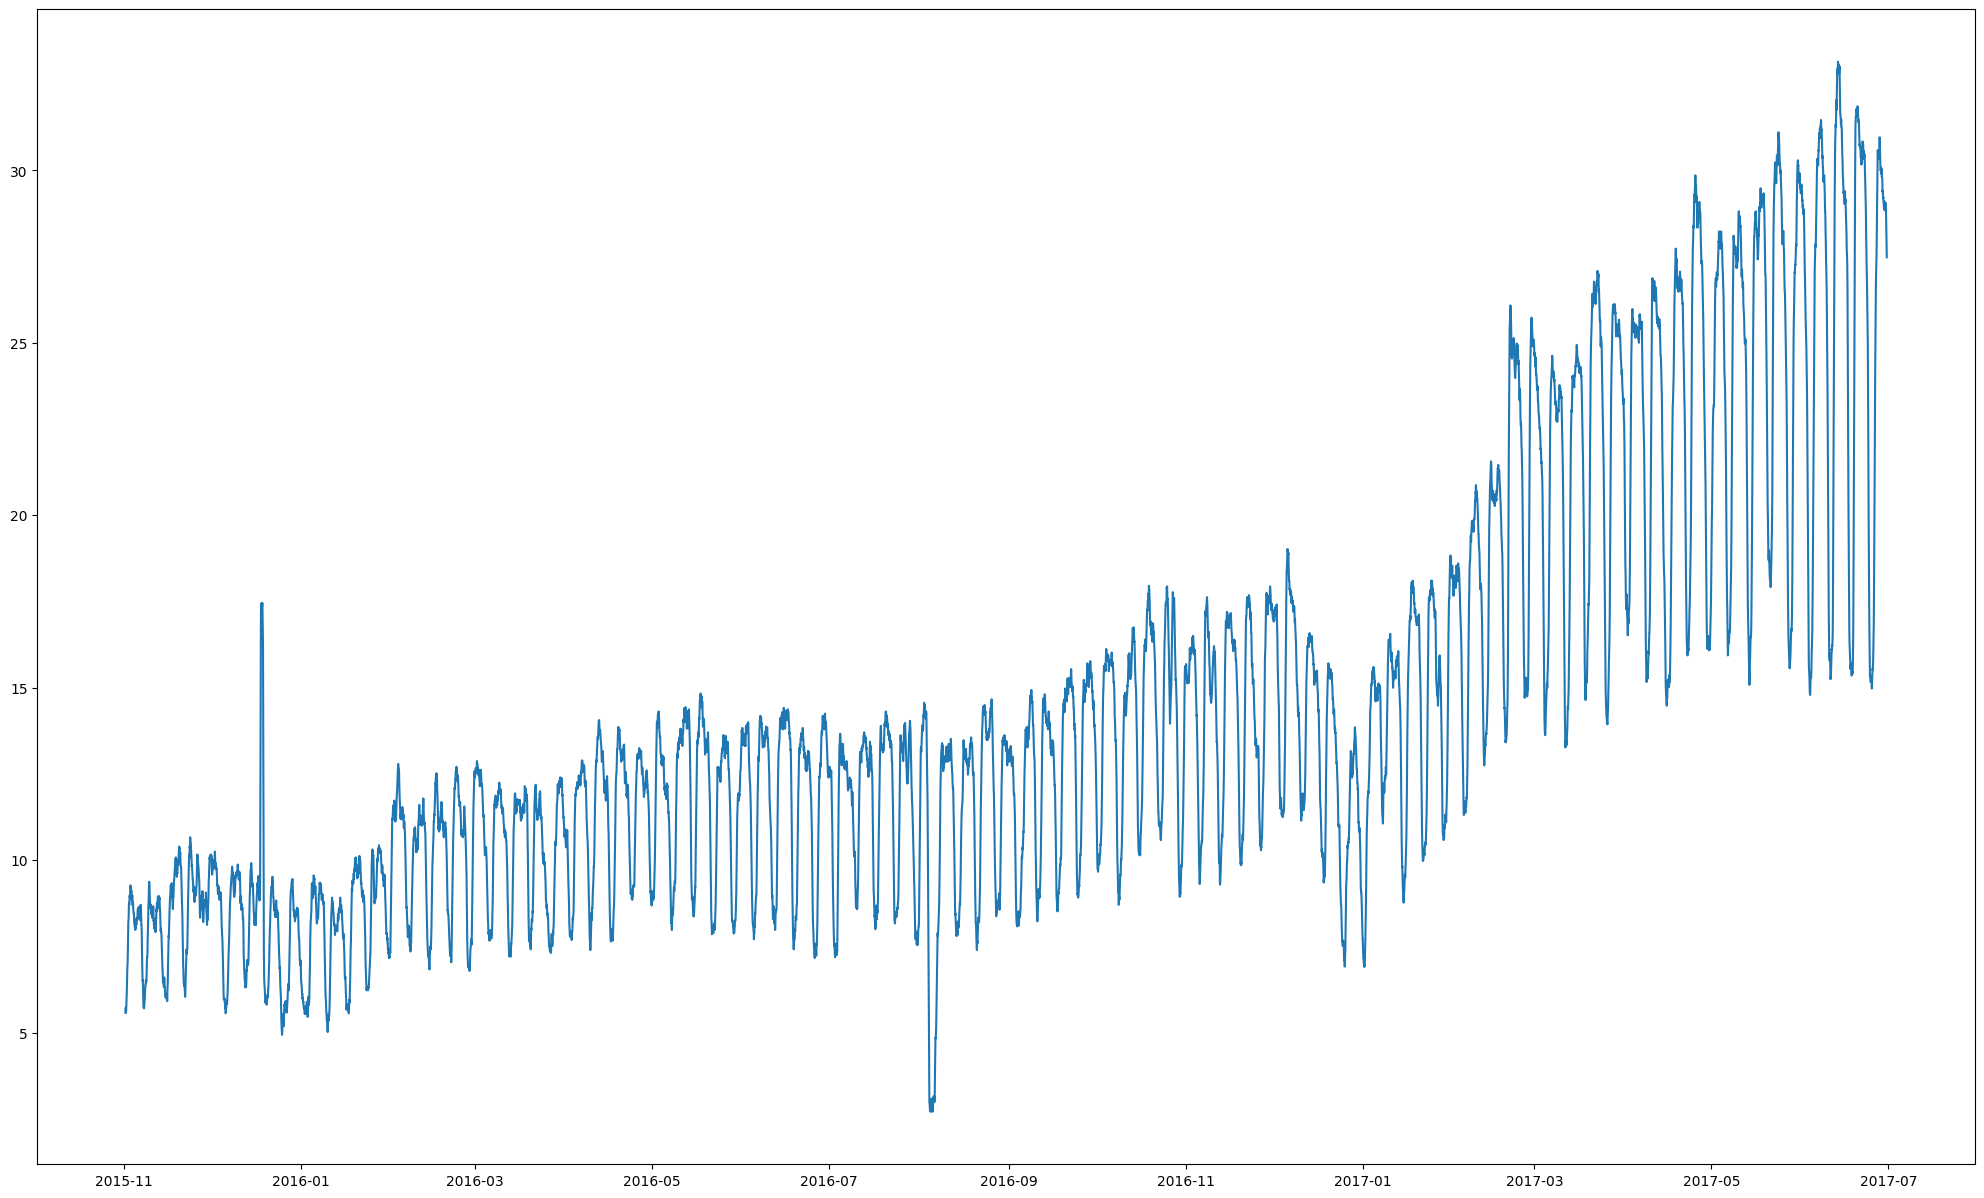

In [13]:
plt.plot(trend)

### Exponencial

In [14]:
def exponential(x,a):
    return a**x + 7.5

In [15]:
x = np.linspace(0, 14568, 14568)
y = trend.dropna(axis=0)
curva, _ = curve_fit(exponential, x, y)
a = curva
y_line = exponential(x, a)

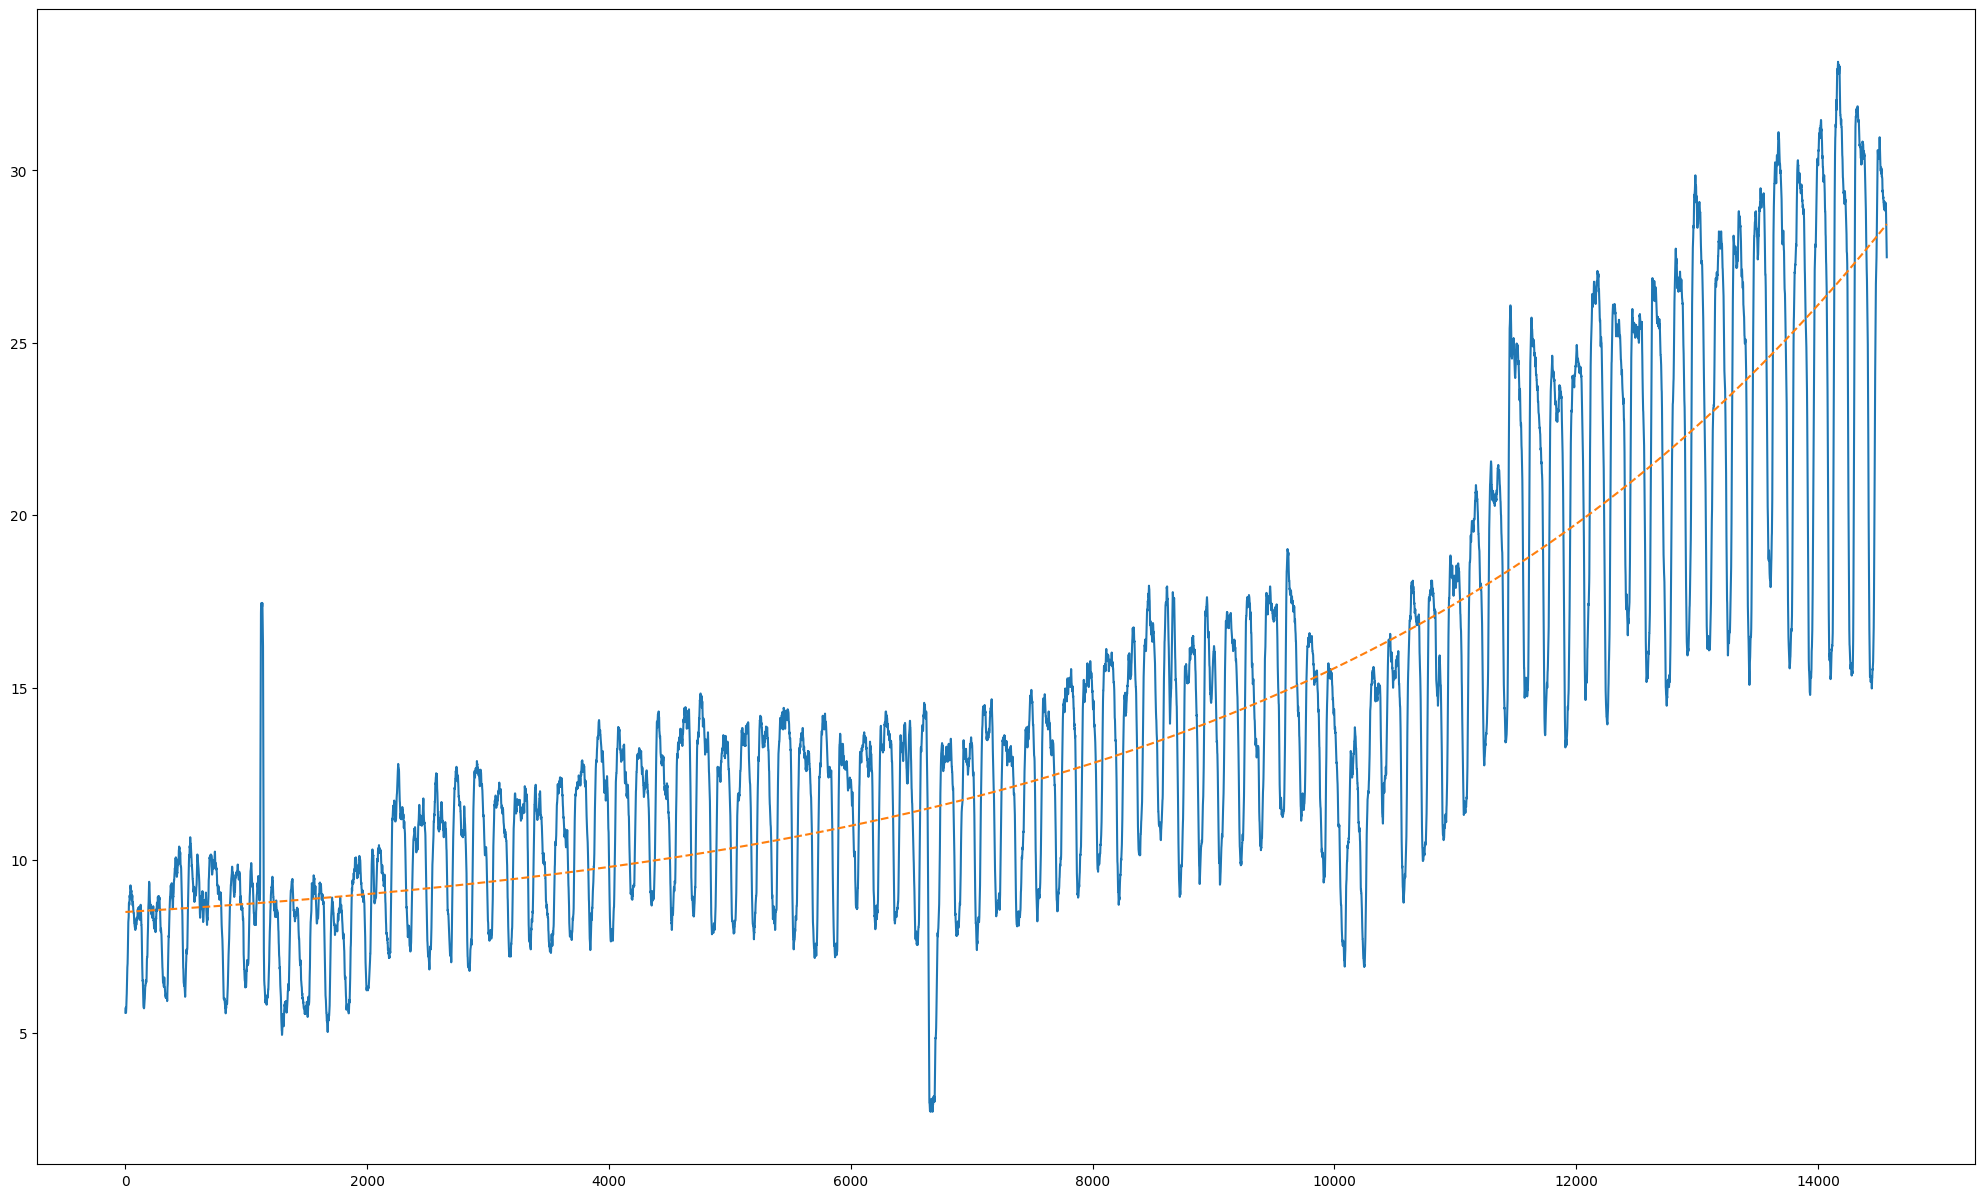

In [16]:
plt.plot(x,y)
plt.plot(x, y_line, '--')

Se puede observar que el modelo se ajusta a la tendencia de una exponencial en lo que se refiere al crecimiento en la cantidad de vehículos a lo largo del tiempo. Sin embargo, este modelo no es suficiente para ajustarse a los ciclos que se presentan respecto a la cantidad de vehículos que pasan en un cruce por hora.

### Cíclico

In [17]:
periodo = 720 #un mes
data_graphic_real=np.array(df['Vehicles'])
rows=int(len(df['Vehicles'])/periodo)
data=np.array(df['Vehicles'])[0:rows*periodo].reshape(rows,periodo)
betas=data.mean(axis=0)

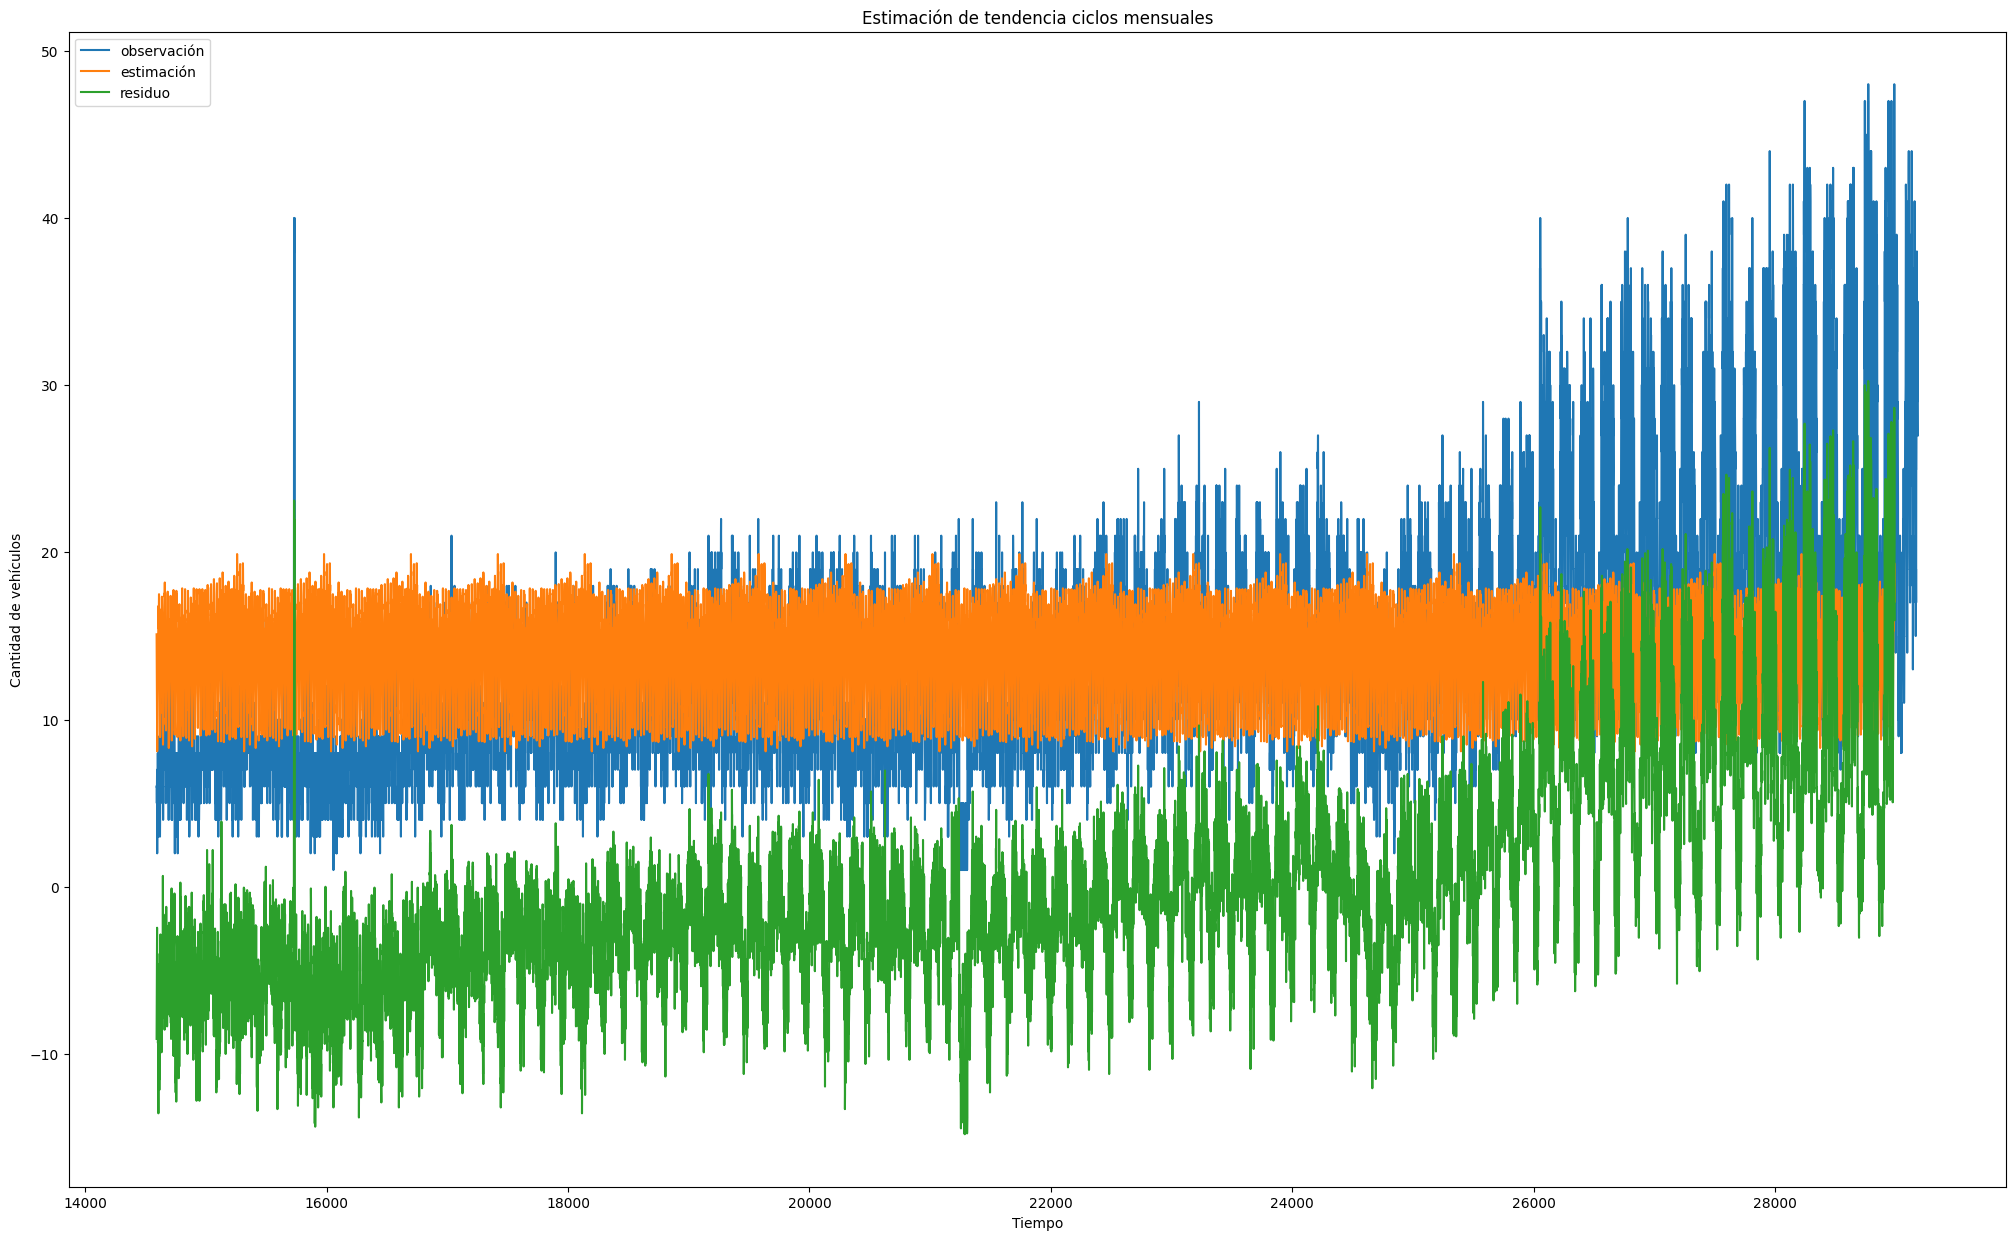

In [18]:
est = np.tile(betas,rows)

plt.plot(df.index,data_graphic_real,label='observación')

plt.plot(df[0:rows*periodo].index,est,label='estimación')

resid=data_graphic_real[0:rows*periodo]-est
plt.plot(df[0:rows*periodo].index,resid,label='residuo')
plt.title("Estimación de tendencia ciclos mensuales")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Cantidad de vehículos")
plt.show()

## Estacionariedad

### Test Dickey-Fuller

In [22]:
t_df = adfuller(df.Vehicles)
t_df

(-8.041077275597704,
 1.846368366770669e-12,
 42,
 14549,
 {'1%': -3.4307995466445482,
  '5%': -2.8617386797172126,
  '10%': -2.566875752496508},
 67639.25742620083)

El p-valor es muy pequeño y el valor estadístico es menor que el umbral en todos los casos, por lo que se podría decir que es estacionaria.

### Test KPSS

In [23]:
t_kpss = kpss(df.Vehicles)
t_kpss

/Users/andavaro/opt/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(15.199407759970098,
 0.01,
 68,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

El p-valor es pequeño y el valor estadístico es mayor que el umbral en todos los casos, por lo que se puede afirmar que la serie es no estacionaria.

### Autocorrelación

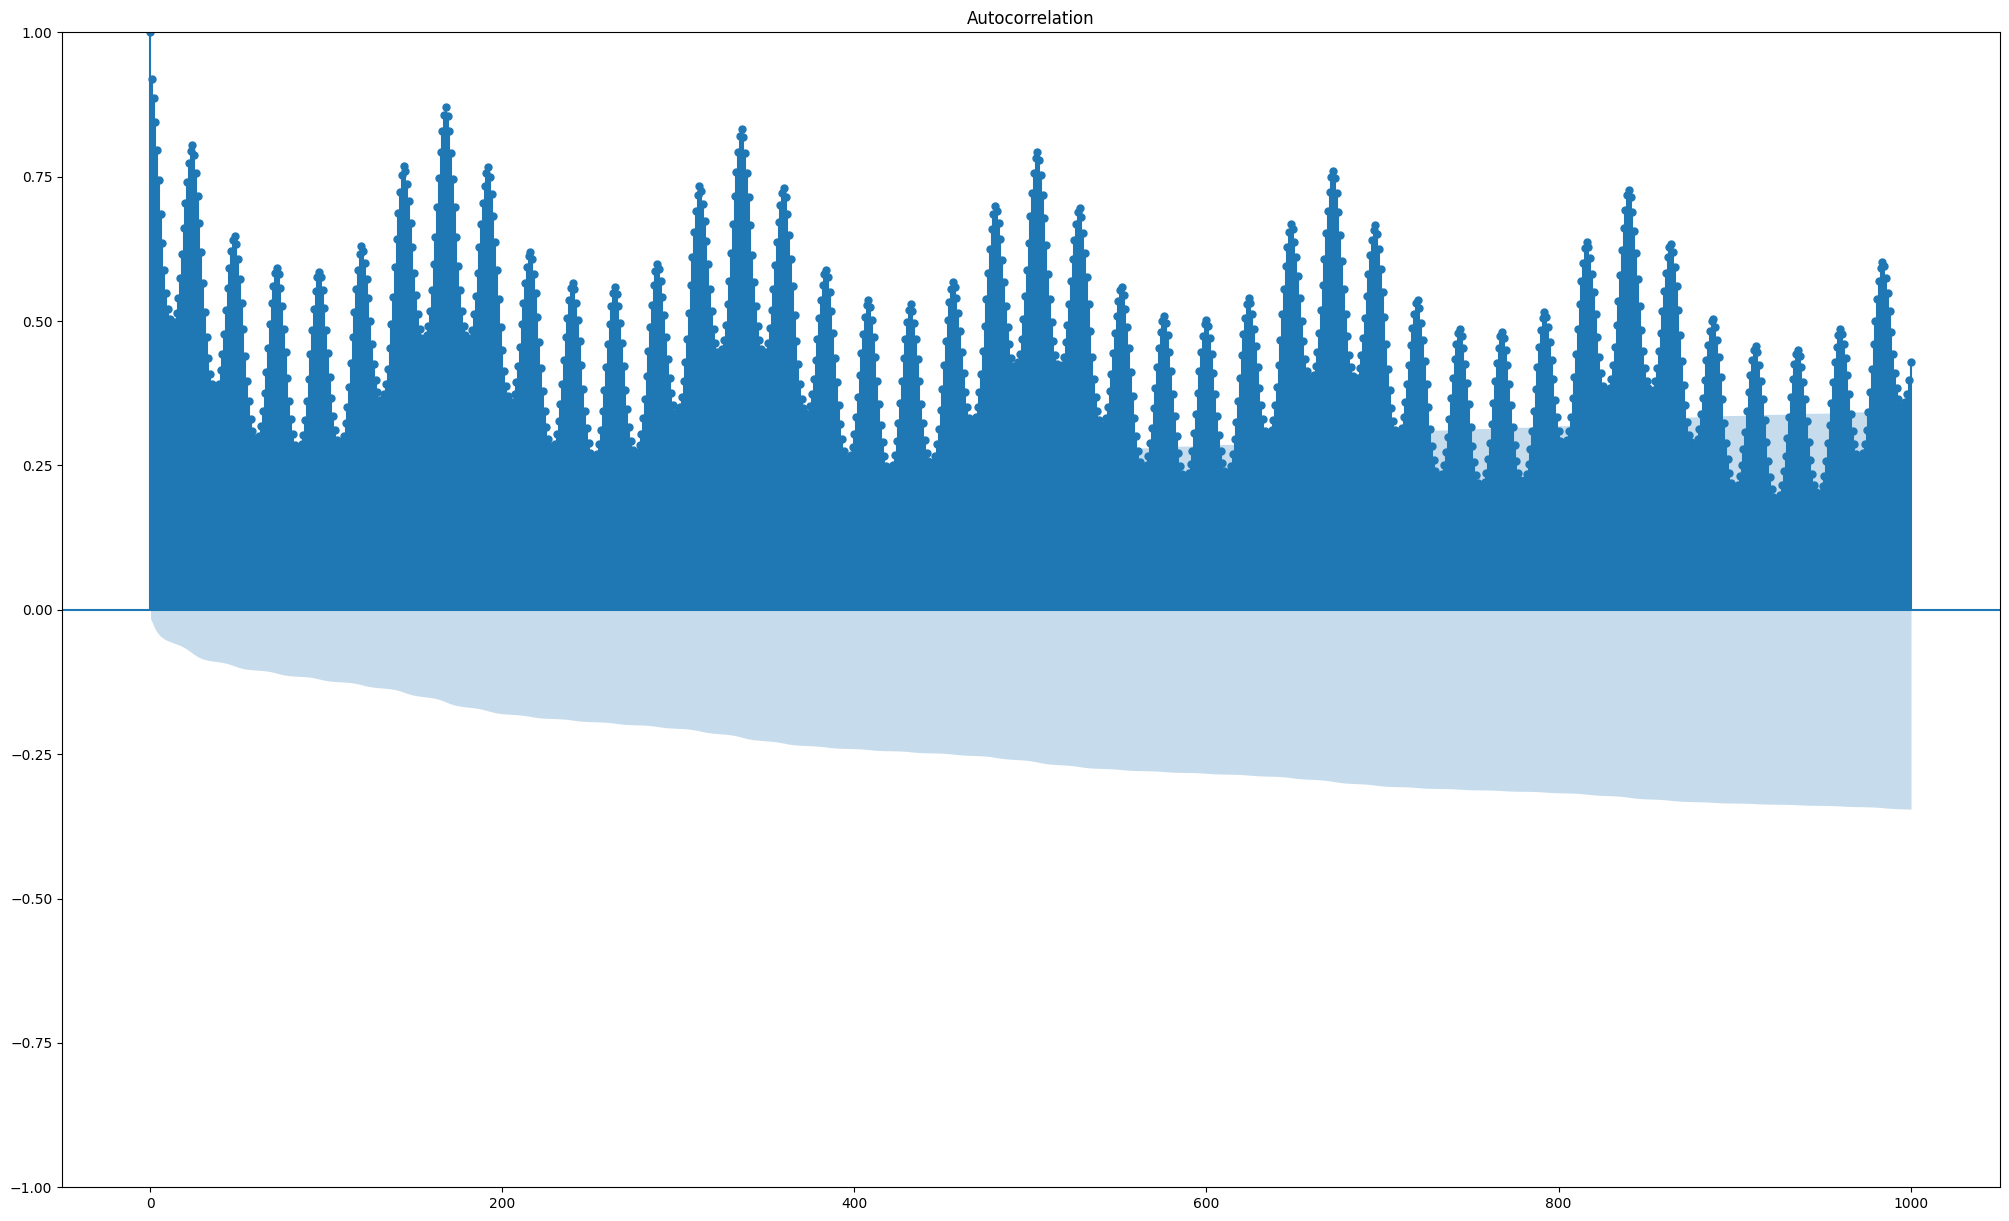

In [24]:
plot_acf(df['Vehicles'], lags=1000)
plt.show()

### Autocorrelación parcial

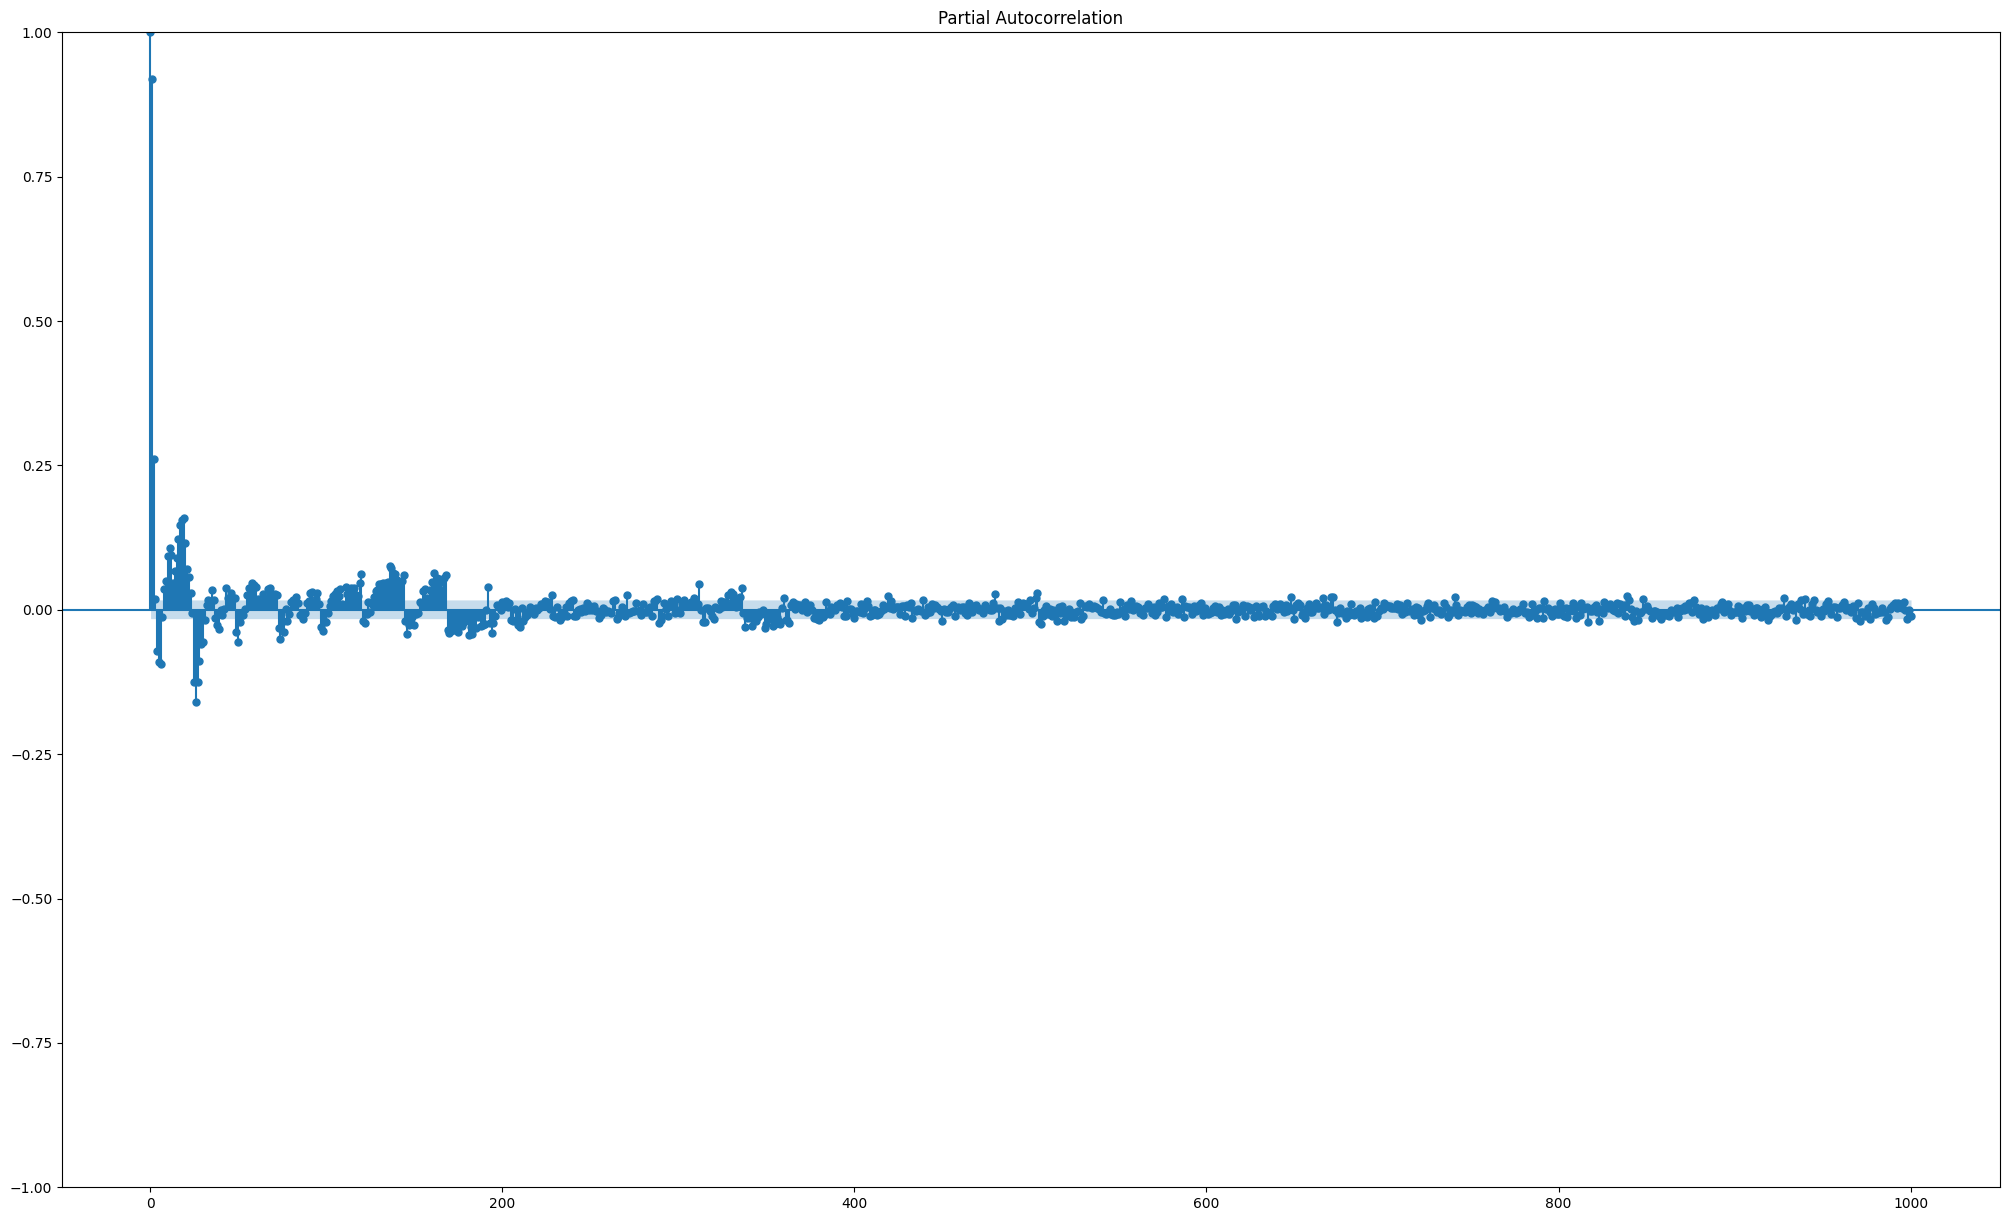

In [25]:
plot_pacf(df['Vehicles'],lags=1000, method='ywm')
plt.show()

### Preprocesamiento

<AxesSubplot: >

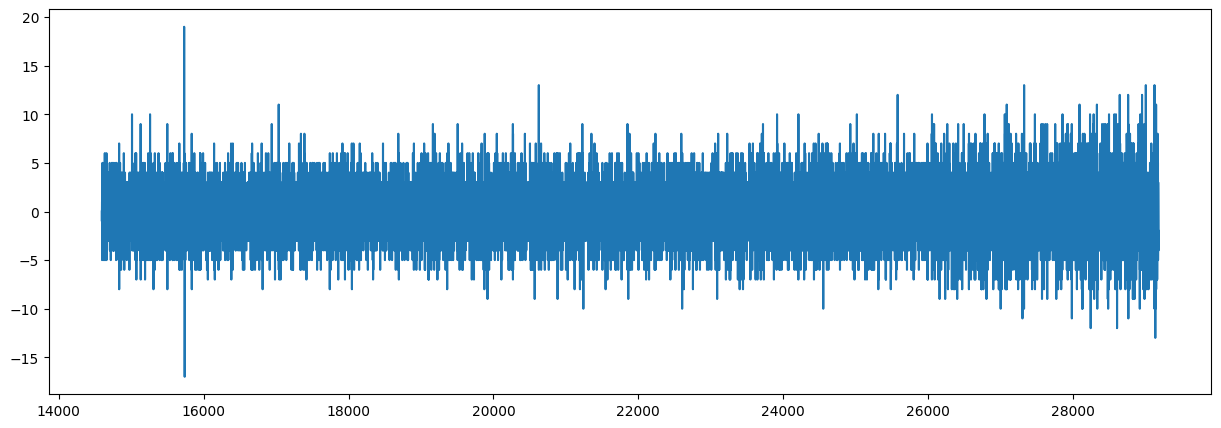

In [26]:
data_diff = df.Vehicles.diff(1)
data_diff.dropna().plot(figsize=(15, 5))

In [27]:
test_diff = adfuller(data_diff.dropna())
test_diff

(-19.733568768619474,
 0.0,
 42,
 14548,
 {'1%': -3.430799577550927,
  '5%': -2.8617386933754303,
  '10%': -2.566875759766632},
 67691.68336572823)

In [28]:
kpss_diff = kpss(data_diff.dropna())
kpss_diff

/Users/andavaro/opt/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.0031823194456422144,
 0.1,
 48,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

## Modelo (S)ARIMA

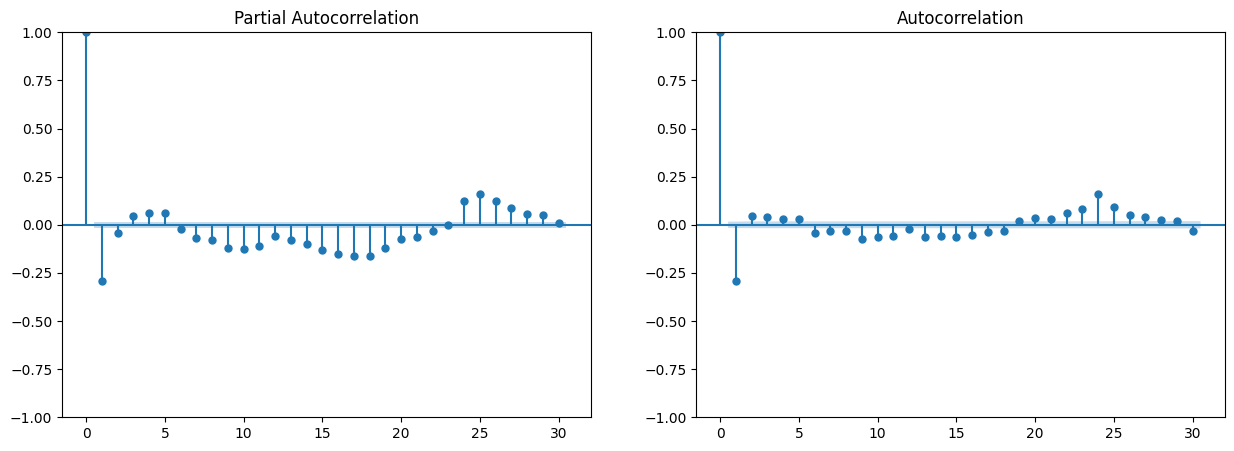

In [29]:
fig = plt.figure(figsize=(15,5))
ax_1 = fig.add_subplot(121)
plot_pacf(data_diff.dropna() ,lags=30, method ="ywm", ax=ax_1)

ax_2 = fig.add_subplot(122)
plot_acf(data_diff.dropna(), lags=30, ax=ax_2);

In [31]:
model = ARIMA(df.Vehicles, order=(3,1,1), seasonal_order=(2,1,1,24))
model_fit = model.fit()
print(model_fit.summary())

/Users/andavaro/opt/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/andavaro/opt/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/andavaro/opt/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/andavaro/opt/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/andavaro/opt/miniconda3/lib/python3.8/site-packages/statsmodels

                                    SARIMAX Results                                     
Dep. Variable:                         Vehicles   No. Observations:                14592
Model:             ARIMA(3, 1, 1)x(2, 1, 1, 24)   Log Likelihood              -33467.199
Date:                          Fri, 07 Apr 2023   AIC                          66950.398
Time:                                  18:52:38   BIC                          67011.090
Sample:                                       0   HQIC                         66970.563
                                        - 14592                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1051      0.035     -3.006      0.003      -0.174      -0.037
ar.L2         -0.0610      0.022     -2.794      0.

In [33]:
model = ARIMA(df.Vehicles, order=(3,1,1), seasonal_order=(0,0,0,0))
model_fit = model.fit()
print(model_fit.summary())

/Users/andavaro/opt/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/andavaro/opt/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/andavaro/opt/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/andavaro/opt/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/andavaro/opt/miniconda3/lib/python3.8/site-packages/statsmodels

                               SARIMAX Results                                
Dep. Variable:               Vehicles   No. Observations:                14592
Model:                 ARIMA(3, 1, 1)   Log Likelihood              -35895.325
Date:                Fri, 07 Apr 2023   AIC                          71800.649
Time:                        18:54:30   BIC                          71838.590
Sample:                             0   HQIC                         71813.254
                              - 14592                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1396      0.083      1.679      0.093      -0.023       0.303
ar.L2          0.1122      0.025      4.442      0.000       0.063       0.162
ar.L3          0.0834      0.008     10.887      0.0

/Users/andavaro/opt/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


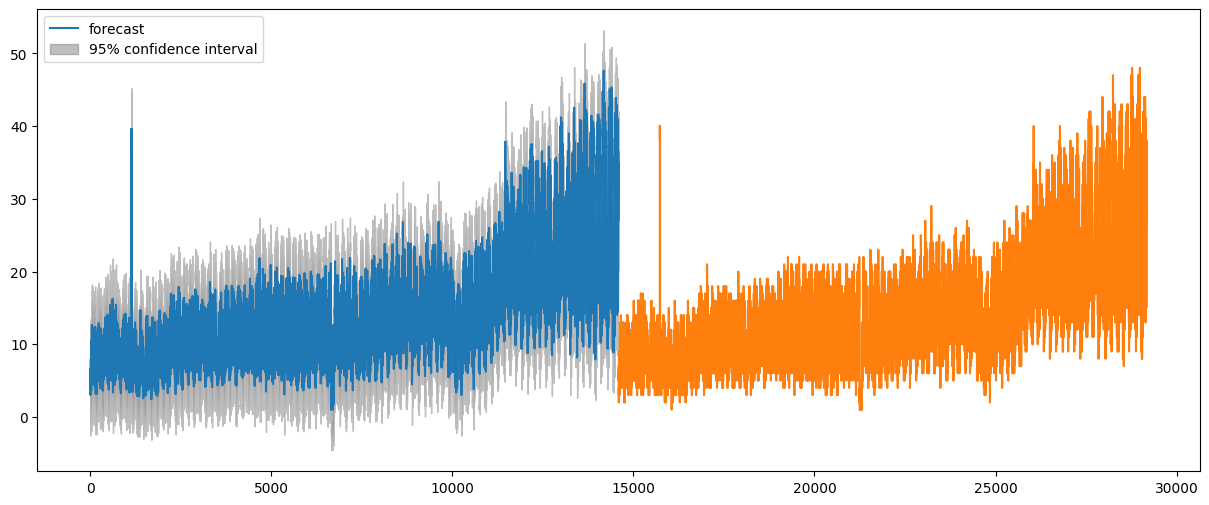

In [34]:
fig, ax = plt.subplots(figsize=(15,6))
fig = plot_predict(model_fit, start= 1, end=len(df.Vehicles) +1 , ax=ax)
plt.plot(df.Vehicles)
legend = ax.legend(loc="upper left")